In [1]:
import pandas as pd

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names


In [2]:
data = pd.read_csv("./criteo_sample.txt")
sparse_features = ["C" + str(i) for i in range(1, 27)]
dense_features = ["I" + str(i) for i in range(1, 14)]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
target = ["label"]
data.head()

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,0.0,3,260.0,0.0,17668.0,0.0,0.0,33.0,0.0,...,e5ba7672,87c6f83c,-1,-1,0429f84b,-1,3a171ecb,c0d61a5c,-1,-1
1,0,0.0,-1,19.0,35.0,30251.0,247.0,1.0,35.0,160.0,...,d4bb7bd8,6fc84bfb,-1,-1,5155d8a3,-1,be7c41b4,ded4aac9,-1,-1
2,0,0.0,0,2.0,12.0,2013.0,164.0,6.0,35.0,523.0,...,e5ba7672,675c9258,-1,-1,2e01979f,-1,bcdee96c,6d5d1302,-1,-1
3,0,0.0,13,1.0,4.0,16836.0,200.0,5.0,4.0,29.0,...,e5ba7672,52e44668,-1,-1,e587c466,-1,32c7478e,3b183c5c,-1,-1
4,0,0.0,0,104.0,27.0,1990.0,142.0,4.0,32.0,37.0,...,e5ba7672,25c88e42,21ddcdc9,b1252a9d,0e8585d2,-1,32c7478e,0d4a6d1a,001f3601,92c878de


In [3]:
# simple transformation for dense features
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

# set the hashing space for each sparse field, and record dense feature field name
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=1000, embedding_dim=4, use_hash=True, dtype='string')
                          for feat in sparse_features] + \
                          [DenseFeat(feat, 1, ) for feat in dense_features]

linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [4]:
# generate input data for model
train, test = train_test_split(data, test_size=0.2, random_state=2020)
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

In [5]:
# define model, train, predict and evaluate
model = DeepFM(linear_feature_columns, dnn_feature_columns, task="binary")
model.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy"])

In [6]:
history = model.fit(train_model_input, train[target].values, batch_size=256, epochs=10, verbose=2, validation_split=0.2,)
pred_ans = model.predict(test_model_input, batch_size=256)

Epoch 1/10
1/1 - 4s - loss: 0.7431 - binary_crossentropy: 0.7431 - val_loss: 0.7559 - val_binary_crossentropy: 0.7559
Epoch 2/10
1/1 - 0s - loss: 0.7207 - binary_crossentropy: 0.7207 - val_loss: 0.7423 - val_binary_crossentropy: 0.7423
Epoch 3/10
1/1 - 0s - loss: 0.7019 - binary_crossentropy: 0.7019 - val_loss: 0.7308 - val_binary_crossentropy: 0.7308
Epoch 4/10
1/1 - 0s - loss: 0.6853 - binary_crossentropy: 0.6853 - val_loss: 0.7195 - val_binary_crossentropy: 0.7195
Epoch 5/10
1/1 - 0s - loss: 0.6691 - binary_crossentropy: 0.6691 - val_loss: 0.7082 - val_binary_crossentropy: 0.7081
Epoch 6/10
1/1 - 0s - loss: 0.6529 - binary_crossentropy: 0.6529 - val_loss: 0.6970 - val_binary_crossentropy: 0.6969
Epoch 7/10
1/1 - 0s - loss: 0.6364 - binary_crossentropy: 0.6364 - val_loss: 0.6856 - val_binary_crossentropy: 0.6856
Epoch 8/10
1/1 - 0s - loss: 0.6198 - binary_crossentropy: 0.6198 - val_loss: 0.6742 - val_binary_crossentropy: 0.6742
Epoch 9/10
1/1 - 0s - loss: 0.6029 - binary_crossentropy

In [8]:
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss 0.6113
test AUC 0.5842


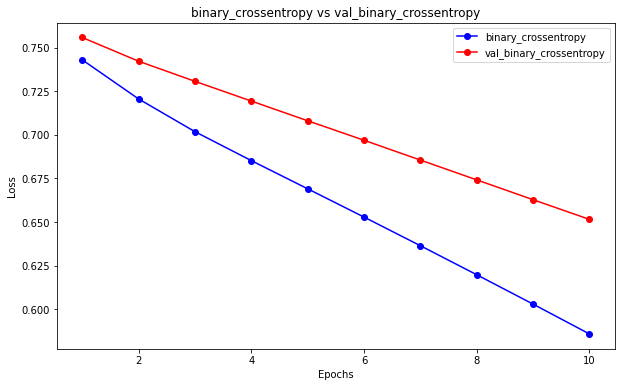

In [10]:
import matplotlib.pyplot as plt
# Extract loss and validation loss values
def plot_history(history, train_metric: str, val_metric: str):
    history_dict = history.history

    loss = history_dict[train_metric]
    val_loss = history_dict[val_metric]
    # Create an array with epoch numbers
    epochs = range(1, len(loss) + 1)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo-', label=train_metric)
    plt.plot(epochs, val_loss, 'ro-', label=val_metric)
    plt.title(f'{train_metric} vs {val_metric}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history, "binary_crossentropy", "val_binary_crossentropy")